# Installing libraries

In [2]:
# !pip3 install pandas numpy matplotlib scikit-learn openpyxl pyarrow scikit-learn seaborn


# Importing relevant libraries

In [13]:
# --- Standard Library ---
import os
from pathlib import Path
from typing import Optional, Dict, List, Tuple
from datetime import datetime, timedelta

# --- Data Manipulation ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn: Model Building & Preprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# --- Scikit-learn: Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- Scikit-learn: Metrics ---
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_recall_fscore_support,
    classification_report, RocCurveDisplay, confusion_matrix
)


# Reading from files

In [43]:
INPATH = Path("jobs.xlsx")
df = pd.read_excel(INPATH)

# Initial Checks

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   time_of_post           9999 non-null   datetime64[ns]
 1   latitude               9999 non-null   float64       
 2   longitude              9999 non-null   float64       
 3   category               9999 non-null   int64         
 4   number_of_tradies      9999 non-null   int64         
 5   estimated_size         9999 non-null   object        
 6   number_of_impressions  9889 non-null   float64       
 7   accepted               9999 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 625.1+ KB


In [45]:
df.head()

,time_of_post,latitude,longitude,category,number_of_tradies,estimated_size,number_of_impressions,accepted
0,2019-09-15 11:40:06,-37.8994,144.9799,8,8376,medium,1004.0,0
1,2019-09-11 15:12:06,-37.8063,144.9964,3,5089,medium,772.0,0
2,2019-09-10 15:53:06,-37.8901,144.8885,7,3677,small,1103.0,0
3,2019-09-10 11:38:06,-33.7674,151.1690,3,9732,medium,1111.0,1
4,2019-09-10 17:38:06,-33.9091,151.2039,6,2476,small,360.0,0


In [46]:
print(f"Rows: {len(df):,}  Cols: {df.shape[1]}")


Rows: 9,999  Cols: 8


In [47]:
df.isna().sum()


time_of_post               0
latitude                   0
longitude                  0
category                   0
number_of_tradies          0
estimated_size             0
number_of_impressions    110
accepted                   0
dtype: int64

In [48]:
print("Duplicate rows:", int(df.duplicated().sum()))

Duplicate rows: 0


In [49]:
print(df.describe(include=[np.number]).T.round(3))

                        count      mean       std      min       25%  \
latitude               9999.0   -34.614     4.787  -38.222   -37.799   
longitude              9999.0   146.509     7.079  121.939   144.938   
category               9999.0     4.820     1.858    1.000     3.000   
number_of_tradies      9999.0  4225.785  3020.932  355.000  1627.000   
number_of_impressions  9889.0  1015.829   481.731 -745.000   689.000   
accepted               9999.0     0.264     0.441    0.000     0.000   

                            50%       75%        max  
latitude                -34.001   -33.842    -17.548  
longitude               145.139   151.206    151.543  
category                  5.000     6.000      9.000  
number_of_tradies      3677.000  7267.000  10000.000  
number_of_impressions  1007.000  1339.000   3245.000  
accepted                  0.000     1.000      1.000  


# DATA CLEANING

In [50]:
df.columns

Index(['time_of_post', 'latitude', 'longitude', 'category',
       'number_of_tradies', 'estimated_size', 'number_of_impressions',
       'accepted'],
      dtype='object')

In [51]:
df['accepted'].unique()

array([0, 1])

In [52]:
print(df['time_of_post'].max(),df['time_of_post'].min())

2019-09-16 22:54:06 2019-09-10 00:01:06


## Impression has NaN AND <0

In [53]:
df['number_of_impressions'].sort_values(ascending=True)


8483   -745.0
1495   -718.0
2031   -642.0
6064   -555.0
6820   -545.0
        ...  
9502      NaN
9517      NaN
9552      NaN
9653      NaN
9864      NaN
Name: number_of_impressions, Length: 9999, dtype: float64

In [54]:
df["estimated_size"].unique()

array(['medium', 'small'], dtype=object)

In [55]:
len(df)

9999

In [56]:
df = df.dropna()
df = df[df['number_of_impressions'] > 0]

In [58]:
len(df)

9760

In [59]:


df['hour'] = df['time_of_post'].dt.hour

# Feature engineering: Region from lat/lon
def get_region(lat, lon):
    if lat > -20 and lon > 120 and lon < 125:  # Broome approx
        return 'WA'
    elif lat > -35 and lat < -32 and lon > 150:  # Sydney approx
        return 'NSW'
    elif lat > -39 and lat < -36 and lon > 144 and lon < 146:  # Melbourne approx
        return 'VIC'
    else:
        return 'Other'

df['region'] = df.apply(lambda row: get_region(row['latitude'], row['longitude']), axis=1)

# # Handle missing/negatives in impressions
# df['number_of_impressions'] = df['number_of_impressions'].replace('', np.nan)
# df['number_of_impressions'].fillna(df['number_of_impressions'].median(), inplace=True)
# df['number_of_impressions'] = df['number_of_impressions'].abs()
# df = df[df['number_of_impressions'] >= 0]

# Encode categoricals
le_size = LabelEncoder()
df['estimated_size_encoded'] = le_size.fit_transform(df['estimated_size'])
le_region = LabelEncoder()
df['region_encoded'] = le_region.fit_transform(df['region'])

# Select features (exclude lat/lon if redundant with region)
features = ['hour', 'number_of_tradies', 'number_of_impressions', 'estimated_size_encoded', 'region_encoded', 'category']
X = df[features]
y = df['accepted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data prepared. X shape:", X.shape, "Imbalance:", y.value_counts(normalize=True))

Data prepared. X shape: (9760, 6) Imbalance: accepted
0    0.735861
1    0.264139
Name: proportion, dtype: float64


In [60]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

# --- Fix chi2 (scale to non-negative) ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=chi2, k=4)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

chi_scores = pd.DataFrame({
    'Feature': features,
    'Chi2 Score': selector.scores_
}).sort_values('Chi2 Score', ascending=False)
print(chi_scores)

# --- Permutation importance ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    'Feature': features,
    'Importance': perm.importances_mean
}).sort_values('Importance', ascending=False)
print(perm_importance)


                  Feature  Chi2 Score
3  estimated_size_encoded  212.837542
1       number_of_tradies  102.785140
0                    hour   72.018092
4          region_encoded    4.959017
5                category    0.667244
2   number_of_impressions    0.000646
                  Feature  Importance
0                    hour    0.073873
3  estimated_size_encoded    0.031660
2   number_of_impressions    0.008811
1       number_of_tradies    0.008453
4          region_encoded   -0.001895
5                category   -0.015676


In [61]:
correlation_matrix = df[['hour', 'number_of_tradies','region_encoded', 'number_of_impressions', 'estimated_size_encoded', 'category','accepted']].corr()
print(correlation_matrix)

                            hour  number_of_tradies  region_encoded  \
hour                    1.000000          -0.009790        0.000172   
number_of_tradies      -0.009790           1.000000        0.198672   
region_encoded          0.000172           0.198672        1.000000   
number_of_impressions   0.003855           0.008589       -0.010727   
estimated_size_encoded  0.007238          -0.016083       -0.001597   
category                0.002345          -0.077495       -0.011907   
accepted                0.295683           0.232365        0.047408   

                        number_of_impressions  estimated_size_encoded  \
hour                                 0.003855                0.007238   
number_of_tradies                    0.008589               -0.016083   
region_encoded                      -0.010727               -0.001597   
number_of_impressions                1.000000               -0.013957   
estimated_size_encoded              -0.013957                1.000

In [62]:
correlation_matrix['accepted']

hour                      0.295683
number_of_tradies         0.232365
region_encoded            0.047408
number_of_impressions     0.001236
estimated_size_encoded   -0.229945
category                 -0.027716
accepted                  1.000000
Name: accepted, dtype: float64

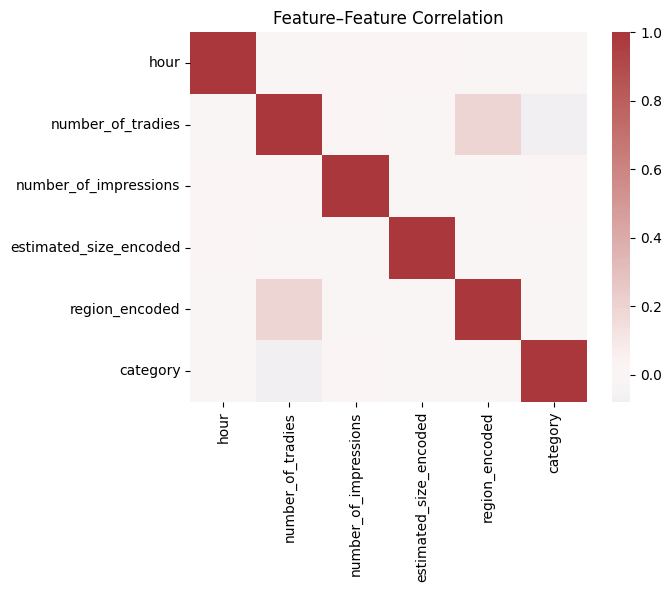

In [63]:
# Correlation among features only
feat_corr = X_train.corr(numeric_only=True)
sns.heatmap(feat_corr, cmap="vlag", center=0)
plt.title("Feature–Feature Correlation")
plt.show()



=== Logistic Regression ===
Accuracy  : 0.7269
Precision : 0.4886
Recall    : 0.7054
F1-score  : 0.5773
ROC AUC   : 0.7818

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.73      0.80      1436
           1       0.49      0.71      0.58       516

    accuracy                           0.73      1952
   macro avg       0.68      0.72      0.69      1952
weighted avg       0.77      0.73      0.74      1952

Confusion Matrix:
 [[1055  381]
 [ 152  364]]


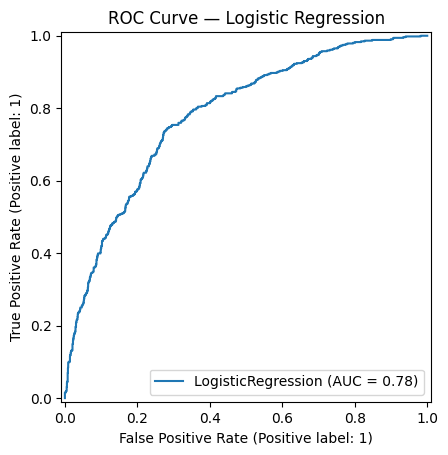

In [65]:
# ============================
# Logistic Regression
# ============================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, roc_auc_score, RocCurveDisplay,
    confusion_matrix
)
import matplotlib.pyplot as plt

# Logistic Regression with balanced class weights (good for imbalance)
logreg = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_score_lr = logreg.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_lr)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_lr, average="binary", zero_division=0)
roc = roc_auc_score(y_test, y_score_lr)

print("\n=== Logistic Regression ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC AUC   : {roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:\n", cm)

# ROC Curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.show()


=== Random Forest ===
Accuracy  : 0.7480
Precision : 0.5305
Recall    : 0.4050
F1-score  : 0.4593
ROC AUC   : 0.7459

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84      1436
           1       0.53      0.41      0.46       516

    accuracy                           0.75      1952
   macro avg       0.67      0.64      0.65      1952
weighted avg       0.73      0.75      0.74      1952

Confusion Matrix:
 [[1251  185]
 [ 307  209]]


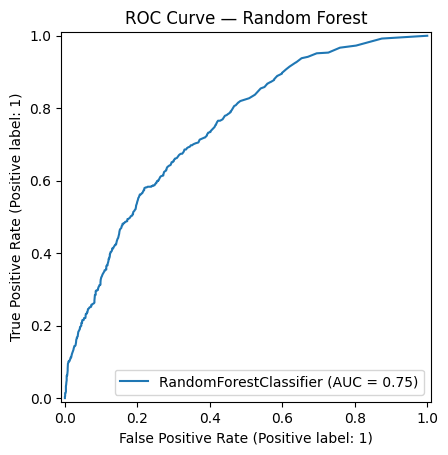

In [66]:
# ============================
# Random Forest
# ============================
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_rf)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average="binary", zero_division=0)
roc = roc_auc_score(y_test, y_score_rf)

print("\n=== Random Forest ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC AUC   : {roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm)

# ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve — Random Forest")
plt.show()

<h1>Logistic Regression</h1>

Accuracy 0.73, ROC-AUC 0.78 → solid discrimination.

Recall = 0.71 (high) but Precision = 0.49 (low).
→ Model catches most accepted jobs (low false negatives), but mislabels quite a few non-accepted as accepted (false positives).

Confusion matrix: predicts many 1’s, leading to higher recall but lower precision.

<h1>Random Forest</h1>

Accuracy 0.75, slightly higher overall than Logistic.

Precision 0.53, better than Logistic.

Recall 0.41, much lower.
→ RF is conservative, predicts fewer accepted jobs, so misses many actual positives but is more precise when it does predict a positive.

ROC-AUC 0.74, a bit weaker than Logistic.


<h1>Overall</h1>
Logistic Regression = higher recall → good if the goal is to not miss potential accepted jobs (more inclusive, but noisier).

Random Forest = higher precision → good if the goal is to be confident about predicted acceptances (fewer false positives, but misses many true positives).

Recall focus (LogReg): better for lead routing, ensuring jobs that might be accepted aren’t missed.

Precision focus (RF): better if follow-up costs are high, and you only want to chase likely acceptances.